In [458]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [459]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

Loss: 22.07408905029297
Loss: 19.750202178955078
Loss: 17.02471351623535
Loss: 17.931671142578125
Loss: 17.12693214416504
Loss: 19.085002899169922
Loss: 17.069656372070312
Loss: 16.87404441833496
Loss: 17.584415435791016
Loss: 19.587657928466797
Loss: 17.843358993530273
Loss: 16.084272384643555
Loss: 16.30745506286621
Loss: 13.555059432983398
Loss: 12.843667030334473
Loss: 12.978116035461426
Loss: 15.194108963012695
Loss: 12.42832088470459
Loss: 17.706945419311523
Loss: 16.129791259765625
Loss: 12.645671844482422
Loss: 13.053628921508789
Loss: 12.405919075012207
Loss: 12.885544776916504
Loss: 12.22281265258789
Loss: 14.866201400756836
Loss: 11.583403587341309
Loss: 13.393974304199219
Loss: 14.852945327758789
Loss: 12.812533378601074
Loss: 12.16469669342041
Loss: 1.8838573694229126
Loss: 12.209527969360352
Loss: 11.028602600097656
Loss: 11.56171703338623
Loss: 11.826268196105957
Loss: 10.515569686889648
Loss: 11.296500205993652
Loss: 10.466718673706055
Loss: 10.712890625
Loss: 11.018736

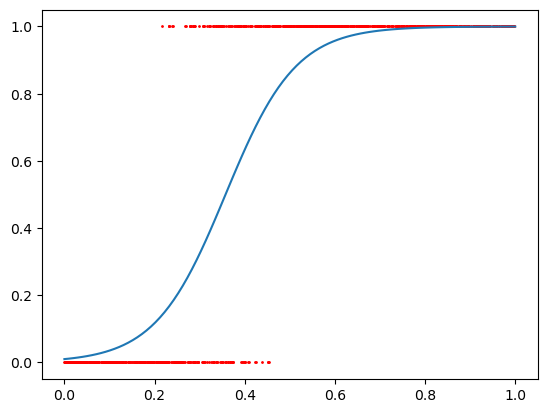

In [460]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)


#Helper variables/functions
alpha = 0.05 #learning rate

for epoch in range(15):
  for x, y in zip(inputs,labels):
    # Calculate p_x as per formula above
    p_x = 1 / (1 + torch.exp(-(b1 + b2*x)))

    # Calculate the negative loss likelihood
    nll = -torch.sum(y * torch.log(p_x) + (1 - y) * torch.log(1 - p_x))

    # Calculate the gradient of the loss w.r.t. the inputs
    partial_b1 = -torch.sum(y - p_x)
    partial_b2 = -torch.sum(x * (y - p_x))

    # Update the parameters b according to SGD formula
    b1 = b1 - alpha * partial_b1
    b2 = b2 - alpha * partial_b2

    # Print out the loss value
    print(f"Loss: {nll.item()}")

# Reproduce the image above to validate your result.
xs = torch.linspace(0, 1, 100)
ys = 1 / (1 + torch.exp(-(b1 + b2*xs)))
plt.plot(xs.detach().numpy(), ys.detach().numpy())

plt.scatter(input.numpy(), label.numpy(), s = 1, c = "r")




In [461]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [462]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.df = self.df.replace("-", np.nan)
        self.df["x"] = pd.to_numeric(self.df["x"])   
        self.df["y"] = pd.to_numeric(self.df["y"])
        

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #return the specified t, x, y as a tensor?
        data_point = self.df.iloc[idx]
        input = torch.Tensor([data_point["t"]])
        labels = torch.Tensor([data_point["x"], data_point["y"]])
        return input, labels



In [466]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(1, 64)
        self.middle_layer = nn.Linear(64, 64)
        self.middle_layer2 = nn.Linear(64, 64)
        self.middle_layer3 = nn.Linear(64, 64)
        self.output_layer = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.tanh(self.input_layer(x))
        x = torch.tanh(self.middle_layer(x))
        x = torch.tanh(self.middle_layer2(x))
        x = torch.relu(self.middle_layer3(x))
        return self.output_layer(x)



In [467]:
url = "https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv"
dataset = TimeSeriesDataset(url) 

trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=0)

def loss_fn(outputs, labels):

    valid_x = ~torch.isnan(labels[:, 0])  # Mask for valid x
    valid_y = ~torch.isnan(labels[:, 1])  # Mask for valid y

    x_MSE = torch.mean((outputs[valid_x, 0] - labels[valid_x, 0]) ** 2)
    y_MSE = torch.mean((outputs[valid_y, 1] - labels[valid_y, 1]) ** 2)
    total_MSE = x_MSE + y_MSE
    return total_MSE

net = Net()
optimizer = optim.Adam(net.parameters())

In [468]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 18.115
[1,    40] loss: 13.602
[1,    60] loss: 14.102
[2,    20] loss: 14.096
[2,    40] loss: 14.194
[2,    60] loss: 12.737
[3,    20] loss: 14.026
[3,    40] loss: 13.396
[3,    60] loss: 13.047
[4,    20] loss: 12.868
[4,    40] loss: 12.913
[4,    60] loss: 14.167
[5,    20] loss: 13.406
[5,    40] loss: 13.309
[5,    60] loss: 12.172
[6,    20] loss: 13.016
[6,    40] loss: 12.683
[6,    60] loss: 11.757
[7,    20] loss: 12.215
[7,    40] loss: 12.895
[7,    60] loss: 12.452
[8,    20] loss: 11.484
[8,    40] loss: 11.996
[8,    60] loss: 11.905
[9,    20] loss: 10.717
[9,    40] loss: 11.671
[9,    60] loss: 11.257
[10,    20] loss: 12.620
[10,    40] loss: 11.148
[10,    60] loss: 10.447
[11,    20] loss: 10.604
[11,    40] loss: 10.993
[11,    60] loss: 10.647
[12,    20] loss: 9.378
[12,    40] loss: 10.196
[12,    60] loss: 10.821
[13,    20] loss: 9.746
[13,    40] loss: 10.622
[13,    60] loss: 9.901
[14,    20] loss: 11.505
[14,    40] loss: 9.327
[14,  

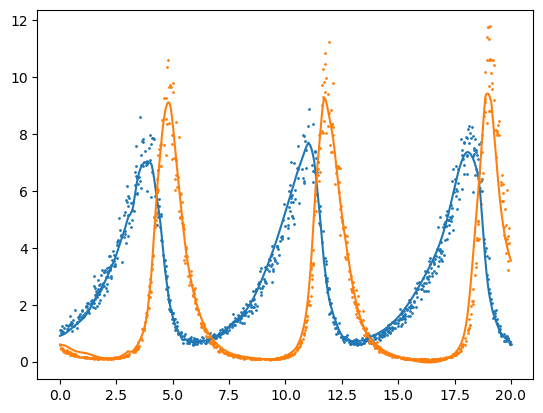

In [469]:
t_test = torch.linspace(0, 20, 10000).view(-1, 1)
net.eval()
output = net(t_test)
x_test = output[:, 0]
y_test = output[:, 1]

fig, ax = plt.subplots()
ax.plot(t_test.numpy(), x_test.detach().numpy())
ax.plot(t_test.numpy(), y_test.detach().numpy())
ax.scatter(dataset[:][0], dataset[:][1][0], s = 1)
ax.scatter(dataset[:][0], dataset[:][1][1], s = 1)



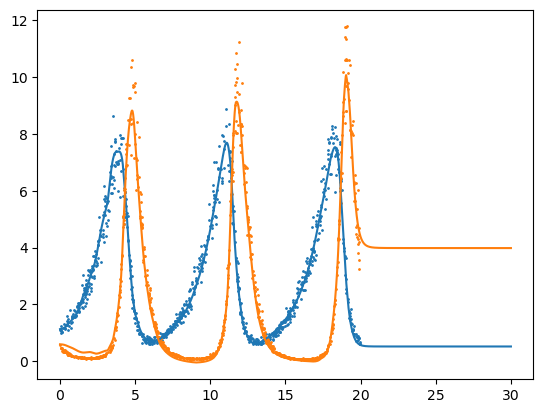

In [454]:
t_test = torch.linspace(0, 30, 1000).view(-1, 1)
net.eval()
output = net(t_test)
x_test = output[:, 0]
y_test = output[:, 1]

fig, ax = plt.subplots()
ax.plot(t_test.numpy(), x_test.detach().numpy())
ax.plot(t_test.numpy(), y_test.detach().numpy())
ax.scatter(dataset[:][0], dataset[:][1][0], s = 1)
ax.scatter(dataset[:][0], dataset[:][1][1], s = 1)

In [455]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        self.input_layer = nn.Linear(3, 64)
        self.middle_layer = nn.Linear(64, 128)
        self.middle_layer2 = nn.Linear(128, 128)
        self.middle_layer3 = nn.Linear(128, 64)
        self.output_layer = nn.Linear(64, 2)

    def forward(self, x):

        x_sin = torch.sin(x)
        x_snake = x + torch.sin(15 * torch.pi * x) ** 2
        x_features = torch.cat([x, x_sin, x_snake], dim=1)


        x = torch.tanh(self.input_layer(x_features))
        x = torch.tanh(self.middle_layer(x))
        x = torch.tanh(self.middle_layer2(x))
        x = torch.relu(self.middle_layer3(x))
        return self.output_layer(x)


In [456]:
net = Net()
optimizer = optim.Adam(net.parameters())

for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 20 == 19:    # print every 20 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

[1,    20] loss: 17.452
[1,    40] loss: 14.495
[1,    60] loss: 14.408
[2,    20] loss: 12.260
[2,    40] loss: 12.428
[2,    60] loss: 11.099
[3,    20] loss: 10.715
[3,    40] loss: 9.364
[3,    60] loss: 10.753
[4,    20] loss: 11.118
[4,    40] loss: 9.459
[4,    60] loss: 8.982
[5,    20] loss: 10.864
[5,    40] loss: 9.238
[5,    60] loss: 8.382
[6,    20] loss: 9.045
[6,    40] loss: 9.117
[6,    60] loss: 8.839
[7,    20] loss: 9.455
[7,    40] loss: 8.347
[7,    60] loss: 8.053
[8,    20] loss: 8.744
[8,    40] loss: 8.305
[8,    60] loss: 6.767
[9,    20] loss: 7.988
[9,    40] loss: 7.399
[9,    60] loss: 6.863
[10,    20] loss: 6.558
[10,    40] loss: 6.685
[10,    60] loss: 6.909
[11,    20] loss: 6.831
[11,    40] loss: 7.511
[11,    60] loss: 5.954
[12,    20] loss: 5.893
[12,    40] loss: 6.390
[12,    60] loss: 7.368
[13,    20] loss: 6.795
[13,    40] loss: 6.344
[13,    60] loss: 5.419
[14,    20] loss: 5.950
[14,    40] loss: 5.627
[14,    60] loss: 5.222
[15,    2

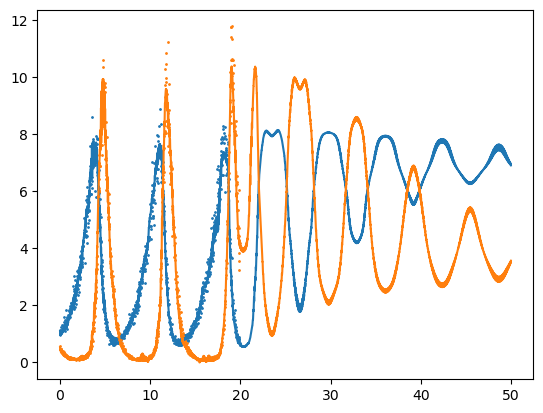

In [457]:
t_test = torch.linspace(0, 50, 10000).view(-1, 1)
net.eval()
output = net(t_test)
x_test = output[:, 0]
y_test = output[:, 1]

fig, ax = plt.subplots()
ax.plot(t_test.numpy(), x_test.detach().numpy())
ax.plot(t_test.numpy(), y_test.detach().numpy())
ax.scatter(dataset[:][0], dataset[:][1][0], s = 1)
ax.scatter(dataset[:][0], dataset[:][1][1], s = 1)

### #3

In [528]:
points = [[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]]
points = np.array(points)
res = 256
sum = 0
canvas = torch.zeros(res, res)
for i in range(res):
    for j in range(res):
        value = [j/(res - 1), i/(res - 1)]
        min_dist = np.Inf
        for point in points:
            dist = np.linalg.norm(point - value)
            if dist < min_dist:
                min_dist = dist
                canvas[i, j] = min_dist


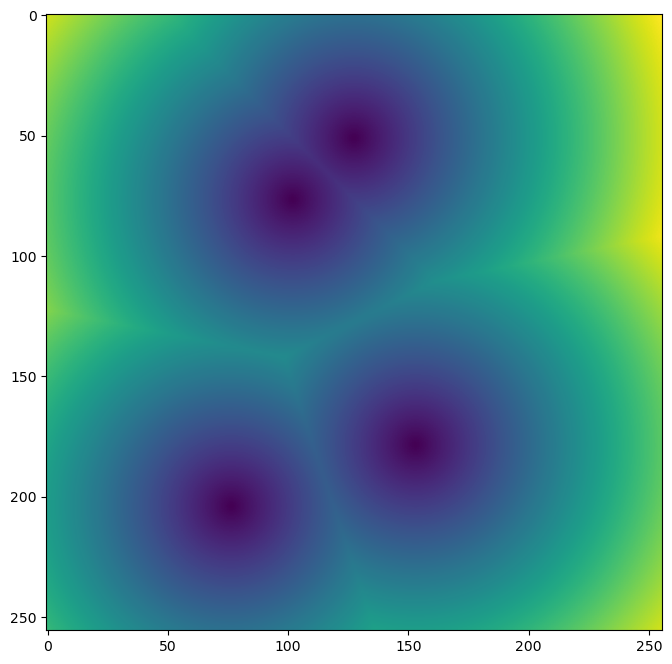

In [529]:
plt.figure(figsize=(8, 8))
plt.imshow(canvas)